In [3]:
# %matplotlib widget
%matplotlib inline

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from mpl_toolkits.axes_grid1 import make_axes_locatable
import Pyro4.util

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
expt_path=os.getcwd()+'/data'
import sys
import scipy as sp
import json

import qutip as qt
import qutip.visualization as qplt

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 16})
style.use('default')

np.set_printoptions(threshold=sys.maxsize)

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


C:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [5]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence

# Run experiment and analysis

In [6]:
# %aimport experiments
# NOTE: ADDING NEW METHODS WILL NOT BE UPDATED
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [7]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [8]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
# expt_path=os.path.join(os.getcwd(), 'data', 'data_240617')
expt_path=os.path.join(data_path, 'data', 'data_241007')
print('Data will be stored in', expt_path)

Data will be stored in S:\QRAM\qram_4QR2\data\data_240617


In [9]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
# config_path = os.path.join(os.getcwd(), config_file)

# config_file = 'config.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)

print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


In [10]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Tomo analysis

In [11]:
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=1)

In [12]:
# 2 cardinal points on Bloch sphere for each measurement axis
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psiX = [1/np.sqrt(2)*(psiZ[0]+psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-psiZ[1])]
psiY = [1/np.sqrt(2)*(psiZ[0]+1j*psiZ[1]), 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])]
psi_dict = dict(Z=psiZ, X=psiX, Y=psiY)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [13]:
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [14]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())

QICK running on ZCU216, software version 0.2.272

Firmware configuration (built Mon Jul 24 13:57:32 2023):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 0 is 0_230, on JHC3
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 1 is 1_230, on JHC4
	2:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 2 is 2_230, on JHC3
	3:	axis_signal_gen_v6 - envelope memory 65536 samples (10.256 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, blk 3 is 3_230, on JHC4
	4:	axis_signal_gen_v6 - envelope memory 65536 samples (9.524 us)
		fs=6881.280 MHz, fabric=430.08

In [ ]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# TURN OFF
lo1.set_standby(True)
lo1.set_output_state(False)

# # TURN ON
# lo1.set_standby(False)
# lo1.set_output_state(True)
# lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
# lo_power = float(yaml_cfg.hw.lo.readout.power)
# lo1.set_frequency(lo_freq) # Set LO frequency
# print('set freq to', lo_freq)
# lo1.set_power(lo_power) # Set LO power
# print('set power to', lo_power)

# Run experiment and acquire data

## QCTRL stuff

In [ ]:
from qctrl import Qctrl
qctrl = Qctrl()

In [ ]:
ctrl_result = qctrl.get_result(action_id=1761100)
# ctrl_result = qctrl.get_result(action_id=1763052)

In [ ]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

times_us = []
I_values_MHz = []
Q_values_MHz = []
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: times_us.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])

    I_values_MHz.append(I_values_q)
    Q_values_MHz.append(Q_values_q)

times_us = np.array(times_us)*1e-3
I_values_MHz = np.array(I_values_MHz)*1e3
Q_values_MHz = np.array(Q_values_MHz)*1e3

plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values_MHz.flatten(), Q_values_MHz.flatten()))))

controls_index = 0
for q in range(4):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    plt.subplot(int(f'41{q+1}'))
    plt.plot(1e3*times_us, I_values_MHz[controls_index], label=f'$I_{q}$')
    plt.plot(1e3*times_us, Q_values_MHz[controls_index], label=f'$Q_{q}$')
    plt.ylim(-ymax, ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1

plt.xlabel('Times [ns]')
plt.tight_layout()
plt.show()

In [ ]:
I_mhz_vs_us = I_values_MHz[0]
Q_mhz_vs_us = Q_values_MHz[0]

ch=1
gencfg = soc['gens'][ch]
maxv = gencfg['maxv']*gencfg['maxv_scale']
samps_per_clk = gencfg['samps_per_clk']
times_cycles = soc.us2cycles(times_us, gen_ch=ch)
times_samps = samps_per_clk * times_cycles
IQ_scale = max((np.max(np.abs(I_mhz_vs_us)), np.max(np.abs(Q_mhz_vs_us))))
I_func = sp.interpolate.interp1d(times_samps, I_mhz_vs_us/IQ_scale, fill_value='extrapolate')
Q_func = sp.interpolate.interp1d(times_samps, Q_mhz_vs_us/IQ_scale, fill_value='extrapolate')
t = np.arange(0, np.round(times_samps[-1]))
iamps = I_func(t)
qamps = Q_func(t)

plt.plot(maxv*iamps)
plt.plot(maxv*qamps)

## Test 1Q tomo

In [ ]:
qubit = 0 # which qubit/resonator we want to probe

In [ ]:
tomo = meas.StateTomography1QExperiment(
    soccfg=soc,
    path=expt_path,
    prefix=f"StateTomoQ{qubit}",
    config_file=config_path,
)

tomo.cfg.expt = dict(
    reps=20000, # reps per measurement basis
    singleshot_reps=20000, # reps per state for singleshot calibration
    qubit=qubit,
    # Icontrols=I_values_MHz[0],
    # Qcontrols=Q_values_MHz[0],
    # times_us=times_us,
)

# print(tomo.cfg)
tomo.go(analyze=False, display=False, progress=True, save=False)

## Qram experiment

In [424]:
meas_order = np.array(['Z', 'X', 'Y'])
# meas_order = np.array(['Z'])

In [425]:
save_data = False

In [454]:
qubit = 1 # which qubit/resonators to do tomo on
# init_state = '|0>|0>' # switch, input
init_state = '|test>'
# init_state = 'Q2Q0_|1>|0>'
# play_pulses = [2, 4] # [1, 3] # [2, 4] # [2, 1, 4, 3]
# play_pulses = [1, 3] # [1, 3] # [2, 4] # [2, 1, 4, 3]
# play_pulses = [1]*8 # Q2/Q1
# play_pulses = [2, 1, 4, 3]
play_pulses = [0]

pi_half_swaps = None
# pi_half_swaps = [True, False]

# cool_qubits = [0, 1]
cool_qubits = None
use_IQ_pulse = True
add_phase = False
readout_cool = True

ZZ_qubit = None
# ZZ_qubit = 0

print('play_pulses', play_pulses)

play_pulses [0]


In [455]:
saved_files = []
qramExpt = meas.QramProtocol1QTomoExperiment(
    soccfg=soc,
    path=expt_path,
    config_file=config_path,
)

span = np.inf
npts = 1
if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

qramExpt.cfg.expt = dict(
    # start=0, # start protocol time [us],
    # step=span/npts, # time step [us], 
    # expts=npts+1, # number of different time experiments - added 1 to include 0 step and full span

    start=span,
    step=0,
    expts=1, # number of different time experiments

    reps=20000, # number of reps per tomo/time step,
    # reps=200, # number of reps per tomo/time step,
    # singleshot_reps=1, # reps per state for singleshot calibration
    singleshot_reps=20000, # reps per state for singleshot calibration
    # singleshot_reps=200, # reps per state for singleshot calibration
    post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
    qubit=qubit,
    init_state=init_state,
    play_pulses=play_pulses,
    
    cool_qubits=cool_qubits,
    use_IQ_pulse=use_IQ_pulse,
    plot_IQ=False,
    
    add_phase=add_phase,
    ZZ_qubit=ZZ_qubit,
    pi_half_swaps=pi_half_swaps,
    
    # readout_cool=readout_cool,
    # n_init_readout=1,
    # n_trig=1,
    # # init_read_wait_us=5,
    # init_read_wait_us=10,
    
    
#     thresholds=[0, 435.2742847736969, 0, 0],
#     angles=[0, -71.14156770965094, 0, 0],
#     ge_avgs=[[0, 0, 0, 0], [-21.004029603255344, 340.8385202238047, 108.85149118006103, 532.2538750050865], [0, 0, 0, 0], [0, 0, 0, 0]] ,
#     counts_calib=[[17573.0, 2427.0], [3659.0, 16341.0]]
    
)

# print(qramExpt.cfg)

try:
    qramExpt.acquire(progress=True, debug=False)
except Exception:
    print("Pyro traceback:")
    print("".join(Pyro4.util.getPyroTraceback()))


  0%|          | 0/2 [00:00<?, ?it/s]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
thresholds=[0, 431.91645454238704, 0, 0],
angles=[0, -51.8325172712065, 0, 0],
ge_avgs=[[0, 0, 0, 0], [101.35949762369792, 303.63968341471355, 265.00418839518227, 511.83801915690105], [0, 0, 0, 0], [0, 0, 0, 0]] ,
counts_calib=[[16794.0, 3206.0], [3613.0, 16387.0]]


  0%|          | 0/3 [00:00<?, ?it/s]

-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase 90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1


In [129]:
saved_files.append(qramExpt.save_data())

Saving S:\QRAM\qram_4QR2\data\data_240617\00094_QramProtocol1QTomo.h5


In [451]:
tomo = qramExpt

### Sweep pi/2 phases

In [462]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [463]:
qubit = 1

In [464]:
span = np.inf
npts = 1
if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))

saved_files = []
save_data = True

# start_phi = -10
# stop_phi = 10
# # n_phi = 30
# n_phi = 21

# phi_sweep = np.linspace(start_phi, stop_phi, n_phi)
# print('phi_sweep', phi_sweep)

# for phi in tqdm(phi_sweep):

center_freq = yaml_cfg.device.qubit.f_ge[qubit*4 + qubit]
span_freq = 0.5
n_freq = 21
freq_sweep = np.linspace(center_freq-span_freq/2, center_freq+span_freq/2, n_freq)
print('freq_sweep', freq_sweep)
for freq in tqdm(freq_sweep):
    
    qramExpt = meas.QramProtocol1QTomoExperiment(
        soccfg=soc,
        path=expt_path,
        config_file=config_path,
    )
    qramExpt.cfg.expt = dict(
        start=span,
        step=0,
        expts=1, # number of different time experiments
    
        reps=15000, # number of reps per tomo/time step,
        # reps=200, # number of reps per tomo/time step,
        # singleshot_reps=1, # reps per state for singleshot calibration
        singleshot_reps=15000, # reps per state for singleshot calibration
        # singleshot_reps=200, # reps per state for singleshot calibration
        post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
        qubit=qubit,
        init_state=init_state,
        play_pulses=play_pulses,
        
        cool_qubits=cool_qubits,
        use_IQ_pulse=use_IQ_pulse,
        plot_IQ=False,
        
        meas_order=['Z'],
        
        add_phase=add_phase,
        ZZ_qubit=ZZ_qubit,
        pi_half_swaps=pi_half_swaps,
    )
    
    # qramExpt.cfg.device.qubit.pulses.pi_ge.half_correction_phase[qubit*4 + qubit] = phi
    qramExpt.cfg.device.qubit.f_ge[qubit*4 + qubit] = freq
    
    try:
        qramExpt.acquire(progress=False, debug=False)
    except Exception:
        print("Pyro traceback:")
        print("".join(Pyro4.util.getPyroTraceback()))
        
    if save_data: saved_files.append(qramExpt.save_data())


freq_sweep [3448.12434469 3448.14934469 3448.17434469 3448.19934469 3448.22434469
 3448.24934469 3448.27434469 3448.29934469 3448.32434469 3448.34934469
 3448.37434469 3448.39934469 3448.42434469 3448.44934469 3448.47434469
 3448.49934469 3448.52434469 3448.54934469 3448.57434469 3448.59934469
 3448.62434469]


  0%|                                                                                           | 0/21 [00:00<?, ?it/s]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00139_QramProtocol1QTomo.h5


  5%|███▉                                                                               | 1/21 [00:23<07:42, 23.13s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00140_QramProtocol1QTomo.h5


 10%|███████▉                                                                           | 2/21 [00:45<07:15, 22.93s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00141_QramProtocol1QTomo.h5


 14%|███████████▊                                                                       | 3/21 [01:08<06:51, 22.86s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00142_QramProtocol1QTomo.h5


 19%|███████████████▊                                                                   | 4/21 [01:31<06:30, 22.94s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00143_QramProtocol1QTomo.h5


 24%|███████████████████▊                                                               | 5/21 [01:54<06:06, 22.90s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00144_QramProtocol1QTomo.h5


 29%|███████████████████████▋                                                           | 6/21 [02:17<05:42, 22.85s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00145_QramProtocol1QTomo.h5


 33%|███████████████████████████▋                                                       | 7/21 [02:40<05:21, 22.95s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00146_QramProtocol1QTomo.h5


 38%|███████████████████████████████▌                                                   | 8/21 [03:03<04:59, 23.04s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00147_QramProtocol1QTomo.h5


 43%|███████████████████████████████████▌                                               | 9/21 [03:26<04:36, 23.03s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00148_QramProtocol1QTomo.h5


 48%|███████████████████████████████████████                                           | 10/21 [03:49<04:12, 22.94s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00149_QramProtocol1QTomo.h5


 52%|██████████████████████████████████████████▉                                       | 11/21 [04:12<03:48, 22.89s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00150_QramProtocol1QTomo.h5


 57%|██████████████████████████████████████████████▊                                   | 12/21 [04:35<03:26, 22.91s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00151_QramProtocol1QTomo.h5


 62%|██████████████████████████████████████████████████▊                               | 13/21 [04:57<03:02, 22.86s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00152_QramProtocol1QTomo.h5


 67%|██████████████████████████████████████████████████████▋                           | 14/21 [05:21<02:40, 22.92s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1


 71%|██████████████████████████████████████████████████████████▌                       | 15/21 [05:43<02:16, 22.82s/it]

Saving S:\QRAM\qram_4QR2\data\data_240617\00153_QramProtocol1QTomo.h5
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00154_QramProtocol1QTomo.h5


 76%|██████████████████████████████████████████████████████████████▍                   | 16/21 [06:07<01:54, 23.00s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00155_QramProtocol1QTomo.h5


 81%|██████████████████████████████████████████████████████████████████▍               | 17/21 [06:30<01:32, 23.03s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00156_QramProtocol1QTomo.h5


 86%|██████████████████████████████████████████████████████████████████████▎           | 18/21 [06:53<01:09, 23.01s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00157_QramProtocol1QTomo.h5


 90%|██████████████████████████████████████████████████████████████████████████▏       | 19/21 [07:15<00:45, 22.95s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00158_QramProtocol1QTomo.h5


 95%|██████████████████████████████████████████████████████████████████████████████    | 20/21 [07:38<00:22, 22.89s/it]

playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
playing phase -90, waveform pi_ge_half_q1, gain 2315, ch 1
-x/2
playing phase -180, waveform pi_ge_half_q1, gain 2315, ch 1
x/2
playing phase 0, waveform pi_ge_half_q1, gain 2315, ch 1
Saving S:\QRAM\qram_4QR2\data\data_240617\00159_QramProtocol1QTomo.h5


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [08:01<00:00, 22.93s/it]


S:\QRAM\qram_4QR2\data\data_240617\00139_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
S:\QRAM\qram_4QR2\data\data_240617\00140_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
S:\QRAM\qram_4QR2\data\data_240617\00141_QramProtocol1QTomo.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_20884\1939458940.py: 13

Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
S:\QRAM\qram_4QR2\data\data_240617\00142_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
S:\QRAM\qram_4QR2\data\data_240617\00143_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
S:\QRAM\qram_4QR2\data\data_240617\00144_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
S:\QRAM\qram_4QR2\data\data_240617\00145_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
S:\QRAM\qram_4QR2\data\data_240617\00146_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
S:\QRAM\qram_4QR2\data\data_240617\00147_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
S:\QRAM\qram_4QR2\data\data_240617\00148_QramProtocol1QTomo.h5
Extrac

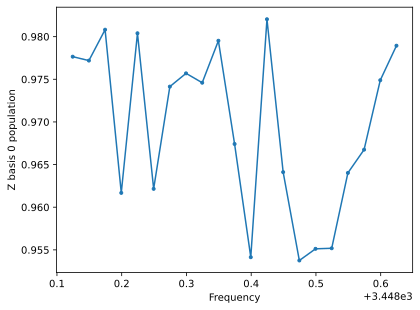

In [465]:
apply_ps = False

all_n_tomo = []
all_n_calib = []
all_Z_vals = []

for i, saved_file in enumerate(saved_files):
    saved_file = saved_file.split('\\')
    # print(saved_file)
    data, attrs = prev_data(expt_path, saved_file[-1])
    cfg = AttrDict(attrs['config'])
    assert np.all(np.array(attrs['calib_order']) == tomo_analysis.calib_order)
    pulse_dict = attrs['pulse_dict']
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust, ps_qubits, apply_ps=apply_ps, verbose=True)
    n_tomo = tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)
    all_Z_vals.append(n_tomo[0][0])

plt.figure()
# plt.plot(phi_sweep, all_Z_vals, '.-')
# plt.xlabel('Phi Correction on all pi/2 gates (deg)')
plt.plot(freq_sweep, all_Z_vals, '.-')
plt.xlabel('Frequency')
plt.ylabel('Z basis 0 population')
plt.show()

## Run analysis

### Get the n_tomo

In [452]:
apply_ps = False
# ps_adjust = [-0.3, -1.0, -0.3, -0.3]
ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [453]:
data = tomo.data
cfg = tomo.cfg
init_state = tomo.cfg.expt.init_state
qubit = tomo.cfg.expt.qubit
pulse_dict = tomo.pulse_dict
assert np.all(np.array(tomo.meas_order) == tomo_analysis.meas_order)

print('meas_order', meas_order)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data=data, cfg=cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, tomo_qubits=[qubit], apply_ps=apply_ps, verbose=True)

print('Tomography counts')
for r in range(n_tomo_raw.shape[0]):
    n_tomo_raw[r,:]/=np.sum(n_tomo_raw[r,:])
print(n_tomo_raw)
print('Confusion matrix counts')
for r in range(n_calib.shape[0]):
    n_calib[r,:]/=np.sum(n_calib[r,:])
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(np.around(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib), decimals=5))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)))

meas_order ['Z' 'X' 'Y']
Tomography counts
[[0.8323 0.1677]
 [0.5155 0.4845]
 [0.4999 0.5001]]
Confusion matrix counts
[[0.8487 0.1513]
 [0.1927 0.8073]]
Confusion matrix corrected tomo matrix will be
[[0.975   0.025  ]
 [0.49207 0.50793]
 [0.46829 0.53171]]


Plot single shot blobs for the X, Y measurements

In [171]:
q = qubit
# q = 0

data = tomo.data
check_states = []

data['iqshots'] = []
iprep_g = 0
iprep_e = 1
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_g, :, -1, :], data[f'calib_qshots_raw'][iprep_g, :, -1, :]))
check_states.append('g')
data['iqshots'].append((data[f'calib_ishots_raw'][iprep_e, :, -1, :], data[f'calib_qshots_raw'][iprep_e, :, -1, :]))
check_states.append('e')

ibasis_Z = 0
ibasis_X = 1
ibasis_Y = 2
data['iqshots'].append((data[f'ishots_raw'][ibasis_Z, :, -1, :], data[f'qshots_raw'][ibasis_Z, :, -1, :]))
check_states.append('Z')
data['iqshots'].append((data[f'ishots_raw'][ibasis_X, :, -1, :], data[f'qshots_raw'][ibasis_X, :, -1, :]))
check_states.append('X')
data['iqshots'].append((data[f'ishots_raw'][ibasis_Y, :, -1, :], data[f'qshots_raw'][ibasis_Y, :, -1, :]))
check_states.append('Y')

play_pulses_list = [] # this is just so we don't print play pulses in the multihist
for check_state in check_states:
    play_pulses_list.append([0])
g_states = [0]
e_states = [1]

meas.single_qubit.single_shot.multihist(
    title=f'Single Shot Q{q} with Multi Readout',
    data=data, check_qubit=q, check_states=check_states, play_pulses_list=play_pulses_list, g_states=g_states, e_states=e_states,
    plot=True, export=True)

g play_pulses [0] unrotated averages:
I 312.75486429036454 +/- 139.52526143064142 	 Q 41.60976643880208 +/- 132.76721241285475 	 Amp 315.5106619440554
Rotated (theta=0.20038108261411808):
I 298.214764268499 +/- 139.6174730205351 	 Q 103.02879293022693 +/- 132.67023967917248 	 Amp 315.5106619440554
e play_pulses [0] unrotated averages:
I 558.6030426269531 +/- 157.45955913643039 	 Q -8.323672314453125 +/- 130.1531840848556 	 Amp 558.6650541718964
Rotated (theta=0.20038108261411808):
I 549.0826081567584 +/- 158.56216047563308 	 Q 103.02879293022694 +/- 128.8076292622643 	 Amp 558.6650541718964
Z play_pulses [0] unrotated averages:
I 558.4575716145833 +/- 158.38334505649868 	 Q -8.148544759114582 +/- 130.92599990852722 	 Amp 558.5170168180632
Rotated (theta=0.20038108261411808):
I 548.905190023926 +/- 159.51539135588206 	 Q 103.17146136479091 +/- 129.54436060251095 	 Amp 558.5170168180634
X play_pulses [0] unrotated averages:
I 441.32416142578126 +/- 191.4607181810232 	 Q 14.28164485677083

([0.6275000000000002], [424.5429299418808], 11.480990328051243)

In [162]:
(498.72-287.84)/(808.256-287.84)

0.4052142901063766

### Reopen old data

In [457]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [461]:
saved_files = ['S:\QRAM\qram_4QR2\data\data_240617\\00123_QramProtocol1QTomo.h5']
data, attrs = prev_data(saved_files[-1], None)
cfg = AttrDict(attrs['config'])
pulse_dict = attrs['pulse_dict']

print(data.keys())
# # data = None
# # style.use('default')
# # qramExpt.analyze(data=data)
# # qramExpt.display(data=data, err=False, saveplot=True)
# # print(data)
print(cfg.device.qubit.pulses.pi_ge.half_correction_phase)

init_state = cfg.expt.init_state
qubit = cfg.expt.qubit
play_pulses = cfg.expt.play_pulses
cool_qubits = cfg.expt.cool_qubits
print('init state', init_state)

n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data=data, cfg=cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, tomo_qubits=[qubit], apply_ps=apply_ps, verbose=True)

print(tomo_analysis.calib_order)

print('Tomography counts')
print(n_tomo_raw)
print('Confusion matrix counts')
print(n_calib)
print('Confusion matrix corrected tomo matrix will be')
print(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib))
# print('Negative counts corrected tomo matrix will be')
# print(tomo_analysis.fix_neg_counts(tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)))

# print(f'thresholds={data["thresholds"].tolist()},')
# print(f'angles={data["angles"].tolist()},')
# print(f'ge_avgs={data["ge_avgs"].tolist()}',',')
# print(f'counts_calib={data["counts_calib"].tolist()}')

S:\QRAM\qram_4QR2\data\data_240617\00123_QramProtocol1QTomo.h5
Extracted data and attrs ['calib_order', 'config', 'meas_order', 'pulse_dict']
dict_keys(['angles', 'calib_ishots_raw', 'calib_qshots_raw', 'counts_calib', 'counts_tomo', 'ge_avgs', 'ishots_raw', 'qshots_raw', 'thresholds'])
[0, 0, 0, 0, 0, -10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
init state |test>
['g' 'e']
Tomography counts
[[8219. 1781.]]
Confusion matrix counts
[[8462. 1538.]
 [2265. 7735.]]
Confusion matrix corrected tomo matrix will be
[[0.96078748 0.03921252]]


 C:\Users\slab\AppData\Local\Temp\ipykernel_20884\1939458940.py: 13

In [ ]:
# qubits = [qubit]
# for basis, pulse_cfgs in tqdm(pulse_dict.items()):
#     for pulse_name, pulse_cfg in pulse_cfgs.items():
#         if pulse_cfg['flag'] != 'ZZcorrection': continue
#         print(pulse_name, pulse_cfg)

Generate test data

In [ ]:
# n_tomo = tomo_analysis.generate_counts(qubits=qubits, rho_id=rho_id, n_tot=1000, noise=1)
# n_calib = qt.qeye(4).full()
# print(n_tomo)

Calculate ideal psi for fidelity calculation. Change this depending on what you want for ideal final state.

In [30]:
# psi_id = 1/np.sqrt(2)*(psiZ[0]-1j*psiZ[1])
# psi_id = (psiZ[0]+psiZ[1]).unit()
psi_id = psiZ[0].unit()

rho_id = qt.ket2dm(psi_id)
print(rho_id)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[1. 0.]
 [0. 0.]]


### Run MLE without ZZ correction

Fidelity (no ZZ correction): 0.01716104983448974
Purity (no ZZ correction): 0.9693277404665714
[[ 0.017+0.j    -0.037+0.012j]
 [-0.037-0.012j  0.983-0.j   ]]


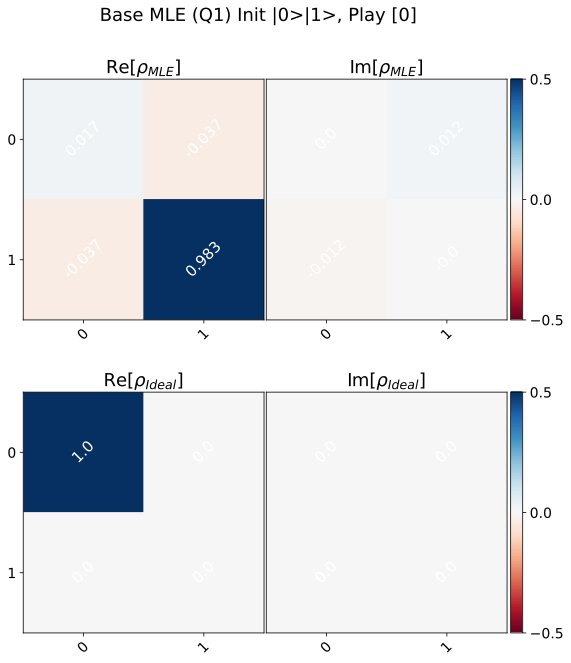

Saved svg: None
Saved data:



In [244]:
# methods = 'Nelder-Mead' 'Powell' 'CG' 'BFGS' 'Newton-CG' 'L-BFGS-B' 'TNC' 'COBYLA' 'SLSQP' 'dogleg' 'trust-ncg'
rho_MLE = tomo_analysis.get_rho_from_counts(
    n_tomo_raw=n_tomo_raw,
    n_calib=n_calib,
    correct_readout=True,
    correct_neg_counts=True,
    method='analytical',
    ZZ_correction=False,
)

if rho_MLE is not None:
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    purity_base = np.real(np.trace(rho_MLE @ rho_MLE))
    print(f'Fidelity (no ZZ correction): {fid_base}')
    print(f'Purity (no ZZ correction): {purity_base}')
print(np.around(rho_MLE, decimals=3))
savetitle=None
# savetitle=saved_files[-1][:-3]+f'_baseMLE_Q{qubit}.svg'
tomo_analysis.show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit}) Init {init_state}, Play {play_pulses}', cmax=0.5, savetitle=savetitle)

print('Saved svg:', savetitle)
print('Saved data:')
print(*saved_files)

In [220]:
phis = [None]
# phis[0] = np.linspace(200, 300, 100)
rho_MLE_rot, best_phis, best_fid = tomo_analysis.opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=phis)
print('best phi', best_phis)
print('best fid', best_fid)

100%|███████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 861.34it/s]

Improved fidelity by (%) 31.30976672156156
best phi [85.23676880222841]
best fid 0.8389423146212142


In [221]:
2*best_phis[0]/8

21.309192200557103

Fidelity (after rotation): 0.9006387865410025
Purity (after rotation): 0.8210737253102929
Target purity: 0.9999999999999996
Best rotation: [115.32033426183844]


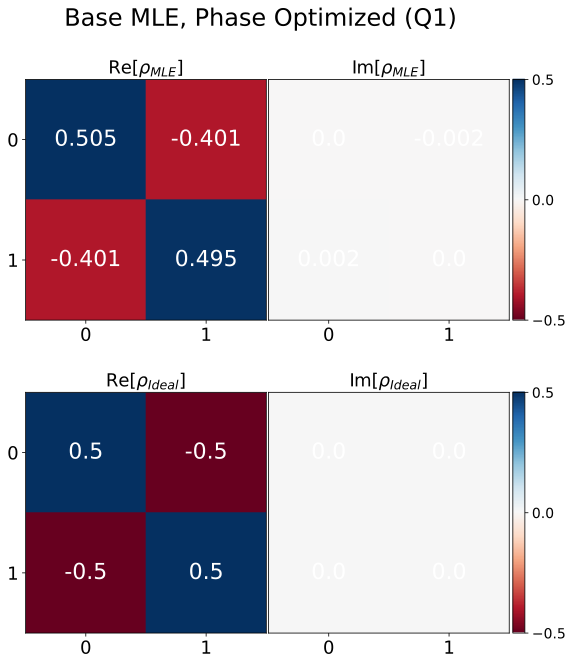

In [118]:
# best_phis = [161.37931034482762, 148.9655172413793, 211.03448275862073]
# best_phis = [310.3448275862069]
# best_phis = [90]
z_phi1 = z_gate_1q(*best_phis)
rho_MLE_rot = (z_phi1*qt.Qobj(rho_MLE, dims=rho_id.dims)*z_phi1.dag()).unit()
fid_rot = qt.fidelity(rho_MLE_rot, rho_id)**2

purity_MLE = np.real(np.trace(rho_MLE @ rho_MLE))
purity_MLE_rot = np.real(np.trace(rho_MLE_rot.full() @ rho_MLE_rot.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity (after rotation): {fid_rot}')
print(f'Purity (after rotation): {purity_MLE_rot}')
print(f'Target purity: {purity_id}')
print(f'Best rotation: {best_phis}')

# print(np.around(rho_MLE_rot, decimals=3))
savetitle=None
tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'Base MLE, Phase Optimized (Q{qubit})', savetitle=savetitle, cmax=0.5)

# Loop over initial states

In [ ]:
save_data = True
init_state_sweep = ['|1>|1>', '|1>|0+1>', '|1>|0>', '|0>|1>', '|0>|0+1>', '|0>|0>']
qubit_sweep = [3, 3, 3, 2, 2, 2]


psi_id_plusj = (psiZ[0]+1j*psiZ[1]).unit()
psi_id_1 = (psiZ[1]).unit()
psi_id_0 = (psiZ[0]).unit()
psi_id_sweep = [psi_id_1, psi_id_plusj, psi_id_0, psi_id_1, psi_id_plusj, psi_id_0]

rho_id_sweep = [qt.ket2dm(psi_id) for psi_id in psi_id_sweep]

# play_pulses = [2, 4] # Q3/Q1
# play_pulses = [1, 3] # Q2/Q1
play_pulses = [2, 1, 4, 3]

meas_order = np.array(['Z', 'X', 'Y'])
# meas_order = ['Z']

num_repeat = 1

In [ ]:
saved_files = []

thresholds = None
angles = None
ge_avgs = None
counts_calib = None


In [ ]:
qubit_prev = -1
for i_rep in range(num_repeat):
    for i_init, init_state in enumerate(init_state_sweep):
        if qubit_sweep[i_init] != qubit_prev:
            thresholds = None
            angles = None
            ge_avgs = None
            counts_calib = None
        qubit_prev = qubit_sweep[i_init]
        print(init_state)
        tomo = meas.QramProtocol1QTomoExperiment(
            soccfg=soc,
            path=expt_path,
            config_file=config_path,
        )
        
        span = np.inf
        npts = 1
        if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
        tomo.cfg.expt = dict(
            start=span,
            step=0,
            expts=1, # number of different time experiments
            reps=30000, # number of reps per tomo/time step,
            singleshot_reps=30000, # reps per state for singleshot calibration
            qubit=qubit_sweep[i_init],
            init_state=init_state,
            play_pulses=play_pulses,
            thresholds=thresholds,
            angles=angles,
            ge_avgs=ge_avgs,
            counts_calib=counts_calib,
        )
        try:
            tomo.go(analyze=False, display=False, progress=False, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))
        
        if save_data: saved_files.append(tomo.save_data())
        data = tomo.data
        if thresholds is None:
            thresholds = data['thresholds']
            angles = data['angles']
            ge_avgs = data['ge_avgs']
            counts_calib = data['counts_calib']
        print()

In [ ]:
print(init_state_sweep)
print(saved_files[0])
print('...')
print(saved_files[-1])

Reconstruct saved_files array

In [ ]:
saved_files = []
start_ind = 0
file_name = '_QramProtocol1QTomo'


# for i in range(len(gain_sweep)*num_repeat):
for i in range(1725, 1730+1):
    ind = i+start_ind
    if ind < 10:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\\data\\0000{ind}{file_name}.h5')
    elif ind < 100:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\\data\\000{ind}{file_name}.h5')
    elif ind < 1000:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\\data\\00{ind}{file_name}.h5')
    elif ind < 10000:
        saved_files.append(f's:\Connie\experiments\qramLL_4QR2\\data\\0{ind}{file_name}.h5')
print(saved_files)

### Calculate fidelities

Full density matrix fidelities with MLE with phase optimization

In [246]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [ ]:
all_n_tomo = []
all_n_calib = []
all_fids = []
all_opt_phis = []
all_fids_rot = []

for i, saved_file in enumerate(saved_files):
    init_state = init_state_sweep[i]
    print('init_state', init_state)
    rho_id = rho_id_sweep[i]
    qubit = qubit_sweep[i]
    
    saved_file = saved_file.split('\\')
    # print(saved_file)
    data, attrs = prev_data(expt_path, saved_file[-1])
    cfg = AttrDict(attrs['config'])
    assert np.all(np.array(attrs['meas_order']) == meas_order)
    assert np.all(np.array(attrs['calib_order']) == calib_order)
    pulse_dict = attrs['pulse_dict']
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust, ps_qubits, apply_ps=apply_ps, verbose=True)

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)

    rho_MLE = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=False,
    )
    
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    tomo_analysis.show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit})', cmax=0.5)

    all_fids.append(fid_base)
    print('fid base', fid_base)
    
    rho_MLE_rot, best_phis, fid_rot = tomo_analysis.opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=opt_phis)
    all_fids_rot.append(fid_rot)
    all_opt_phis.append(best_phis)
    tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'Base MLE, Phase Optimized (Q{qubit})', savetitle=None, cmax=0.5)
    print('fid rot', fid_rot)

In [ ]:
print('init states', init_state_sweep)
print('fids', all_fids)
print('opt phis', all_opt_phis)
print('fids_rot', all_fids_rot)

# Loop over 2Q sweep parameters

In [50]:
save_data = True
cool_qubits = None

# Q3/Q1 sweep
# gain_sweep = np.linspace(5000, 30000, 30)
# opt_lens=[0.9310686145098293, 0.7907034255938805, 0.6915138305418848, 0.610172449896178, 0.5535607384451522, 0.4959725820840996, 0.4313413597995417, 0.43145505526382266, 0.38998990928397637, 0.36818768591932416, 0.3419146574873112, 0.3241070847910494, 0.30379366384188117, 0.29356115615478817, 0.27708301555782117, 0.26762018208409394, 0.2522110834653566, 0.2449035633993692, 0.23500664404458893, 0.22690111620130468, 0.21550254879409964, 0.20813271907918016, 0.20289662908828981, 0.19526861930015801, 0.19023091486190713, 0.18203709188337802, 0.17797794550344453, 0.17380377952162981, 0.16411911946000374, 0.15514127497927613]
# opt_freqs=[5149.8, 5149.755172413794, 5149.610344827586, 5149.4655172413795, 5149.120689655172, 5148.975862068965, 5149.031034482759, 5148.586206896552, 5148.041379310345, 5147.896551724138, 5147.351724137931, 5147.006896551724, 5147.262068965517, 5146.7172413793105, 5145.772413793104, 5145.527586206897, 5145.482758620689, 5144.737931034483, 5144.293103448276, 5143.8482758620685, 5142.803448275862, 5142.1586206896545, 5142.013793103449, 5141.568965517241, 5140.724137931034, 5140.579310344828, 5139.73448275862, 5139.189655172414, 5138.944827586207, 5138.6]

# gain_sweep=[14000, 14000, 14321, 14642, 14964, 15285, 15607, 15928, 16250, 16571, 16892, 17214, 17535]
# opt_lens=[0.33659605702795414, 0.3381497949209947, 0.3281553141321123, 0.3233335405598167, 0.31539084536559703, 0.3119196200721614, 0.3047974366625188, 0.29723608375059285, 0.2926523940231494, 0.2861865805714239, 0.27580639845115373, 0.2738646666898287, 0.2728043628337166]
# opt_freqs=[5147.333333333333, 5147.333333333334, 5147.306547619048, 5147.196428571428, 5147.086309523809, 5146.913690476191, 5146.7827380952385, 5146.630952380952, 5146.5, 5146.327380952382, 5146.175595238095, 5145.982142857143, 5145.91369047619]


# Q2/Q1 sweep
gain_sweep = np.linspace(5000, 30000, 30)
opt_lens=[1.5838399273965433, 1.3378345833581047, 1.1676377168422911, 1.0367219889024542, 0.9312995150158446, 0.8571122465520258, 0.7652891331757938, 0.7250929596858597, 0.6774951951737476, 0.6247710923605944, 0.582374496788368, 0.5593159101678329, 0.5303422843446524, 0.5084159319106835, 0.4890275104286735, 0.4592233833892837, 0.4477794516068375, 0.43910961278454363, 0.4200639806435553, 0.4130039635486878, 0.3971451358441858, 0.3871374262491617, 0.3771953251039537, 0.37069944665894383, 0.3574767858016301, 0.34805638669282907, 0.34159373502297524, 0.34077001921540484, 0.33518554698709696, 0.3261001701564052]
opt_freqs=[5886.25, 5886.19540229885, 5886.140804597701, 5886.002873563219, 5885.948275862069, 5885.810344827586, 5885.922413793103, 5885.6178160919535, 5885.646551724138, 5885.508620689655, 5885.120689655172, 5884.982758620689, 5884.8448275862065, 5884.706896551724, 5884.902298850574, 5884.347701149426, 5884.293103448276, 5884.2385057471265, 5884.017241379311, 5884.045977011495, 5883.908045977012, 5883.686781609195, 5883.3821839080465, 5883.327586206897, 5883.439655172414, 5883.385057471264, 5882.747126436781, 5882.859195402299, 5882.637931034483, 5882.333333333333]

gain_sweep = gain_sweep[14:23]
opt_lens = opt_lens[14:23]
opt_freqs = opt_freqs[14:23]


# npts = 5
# gain_sweep = [12291]*npts
# opt_lens = [0.423]*npts
# # opt_lens = np.linspace(0, 2*423, npts)
# opt_freqs = [5884.144166666667]*npts
# opt_freqs = np.linspace(5885.04+300, 5885.041666666667)

# gain_sweep = [22708]*npts
# opt_lens = [0.3178934468718401]*npts
# # opt_lens = np.linspace(0, 2*423, npts)
# opt_freqs = [5144.32]*npts
# # opt_freqs = np.linspace(5885.04+300, 5885.041666666667)

sweep2Q_q = 2
qubit = 2 # 1q tomo measurement qubit

# sweep2Q_q = 3
# qubit = 3 # 1q tomo measurement qubit


# psi_id = (psiZ[0]+psiZ[1]).unit()
# rho_id = qt.ket2dm(psi_id)
# init_state = '|0+1>|1>'
# # play_pulses = [2, 4] # Q3/Q1
# play_pulses = [1, 3] # Q2/Q1


# PLAY FORBIDDEN PULSES
psi_id = psiZ[0]
rho_id = qt.ket2dm(psi_id)

# # Q3/Q1 calibration (measure qubit=3)
init_state = '|0>|1>' # Q2/Q1 init state
# play_pulses = [2, 4] # Q3/Q1 swap
# # cool_qubits = [0, 1]

# Q2/Q1 calibration (measure qubit=2)
# init_state = '|1>|1>' # Q3/Q1 init state
play_pulses = [1, 3] # Q2/Q1 swap
# # cool_qubits = [0, 1]

# Check heating
# init_state = '|0>|0>'

# play_pulses = [0]

# meas_order = None
meas_order = ['Z']

num_repeat = 3


print('gain_sweep', np.array(gain_sweep).tolist())
print('opt_lens', np.array(opt_lens).tolist())
print('opt_freqs', np.array(opt_freqs).tolist())
print('save data', save_data)
print('sweep2Q_q', sweep2Q_q, 'measure qubit', qubit)
print('init state', init_state)
print('play pulses', play_pulses)


gain_sweep [17068.96551724138, 17931.034482758623, 18793.103448275862, 19655.1724137931, 20517.241379310344, 21379.310344827587, 22241.379310344826, 23103.44827586207, 23965.51724137931]
opt_lens [0.4890275104286735, 0.4592233833892837, 0.4477794516068375, 0.43910961278454363, 0.4200639806435553, 0.4130039635486878, 0.3971451358441858, 0.3871374262491617, 0.3771953251039537]
opt_freqs [5884.902298850574, 5884.347701149426, 5884.293103448276, 5884.2385057471265, 5884.017241379311, 5884.045977011495, 5883.908045977012, 5883.686781609195, 5883.3821839080465]
save data True
sweep2Q_q 2 measure qubit 2
init state |0>|1>
play pulses [1, 3]


In [51]:
opt_phis = [None]
thresholds = None
angles = None
ge_avgs = None
counts_calib = None

In [52]:
count = 0

expt_sweep = Experiment(
    path=expt_path,
    prefix=f"eggf_1qtomo_sweepQ{sweep2Q_q}_tomoQ{qubit}",
    config_file=config_path,
)
expt_sweep.data = dict(gain_sweep=[], len_sweep=[], freq_sweep=[])

for i_rep in range(num_repeat):
    for i_gain, gain in enumerate(tqdm(gain_sweep)):
        # if count < 396:
        #     count += 1
        #     continue
            
        tomo = meas.QramProtocol1QTomoExperiment(
            soccfg=soc,
            path=expt_path,
            config_file=config_path,
            prefix=f"QramProtocol_EgGfsweepQ{sweep2Q_q}_1QTomoQ{qubit}",
        )
        
        span = np.inf
        npts = 1
        if span < np.inf: print('time step size [cycles]:', soc.us2cycles(span/npts))
    
        tomo.cfg.expt = dict(
            start=span,
            step=0,
            expts=1, # number of different time experiments
            reps=30000, # number of reps per tomo/time step,
            singleshot_reps=30000, # reps per state for singleshot calibration
            post_process='scale', # 'threshold', (uses single shot binning), 'scale' (scale by ge_avgs), or None
            qubit=qubit,
            init_state=init_state,
            play_pulses=play_pulses,
            meas_order=meas_order,
            thresholds=thresholds,
            angles=angles,
            ge_avgs=ge_avgs,
            counts_calib=counts_calib,
            cool_qubits=cool_qubits,
        )

        if i_rep == 0 and i_gain == 0:
            expt_sweep.cfg = tomo.cfg
            expt_sweep.data['num_repeat'] = 0
        
        tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q] = int(gain)
        tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q] = opt_lens[i_gain]
        tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q] = opt_freqs[i_gain]
        # print('gain', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.gain[sweep2Q_q],
        #       'len', tomo.cfg.device.qubit.pulses.pi_EgGf_Q.sigma[sweep2Q_q],
        #       'freq', tomo.cfg.device.qubit.f_EgGf_Q[sweep2Q_q])
        
        success = False
        while not success:
            try:
                tomo.acquire(debug=False, progress=False)
                success = True
            except Exception:
                print("Pyro traceback:")
                print("".join(Pyro4.util.getPyroTraceback()))
        
        expt_sweep.data['gain_sweep'].append(int(gain))
        expt_sweep.data['freq_sweep'].append(opt_freqs[i_gain])
        expt_sweep.data['len_sweep'].append(opt_lens[i_gain])
        for data_key in tomo.data.keys():
            if data_key not in expt_sweep.data.keys():
                expt_sweep.data[data_key] = []
            # if i_rep == 0 and i_gain == 0: print('updated saved data', data_key)
            expt_sweep.data[data_key].append(tomo.data[data_key])
        
        # if save_data: saved_files.append(tomo.save_data())
            
        data = tomo.data
        if thresholds is None:
            thresholds = data['thresholds']
            angles = data['angles']
            ge_avgs = data['ge_avgs']
            counts_calib = data['counts_calib']
    expt_sweep.data['num_repeat'] += 1
    if save_data: expt_sweep.save_data()

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:15<00:00, 15.09s/it]


In [53]:
print(expt_sweep.save_data())
data = expt_sweep.data
cfg = expt_sweep.cfg

S:\Connie\experiments\qramLL_4QR2\data\data_240617\00002_eggf_1qtomo_sweepQ2_tomoQ2.h5


Replot data above

Reopen data

In [54]:
saved_file = 'S:\Connie\experiments\qramLL_4QR2\data\data_240617\\00002_eggf_1qtomo_sweepQ2_tomoQ2.h5'
data, attrs = prev_data(expt_path=saved_file)
cfg = AttrDict(attrs['config'])

S:\Connie\experiments\qramLL_4QR2\data\data_240617\00002_eggf_1qtomo_sweepQ2_tomoQ2.h5


 C:\Users\slab\AppData\Local\Temp\ipykernel_21116\1939458940.py: 13

Extracted data and attrs ['config']


### Calculate fidelities

In [246]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

Full density matrix fidelities with MLE with phase optimization /next cell should be skipped

In [ ]:
all_n_tomo = []
all_n_calib = []
all_fids = []
all_fids_rot = []

# data = expt_sweep.data
# cfg = expt_sweep.cfg

for iexpt in range(len(data['gain_sweep'])):
    assert np.all(np.array(data['meas_order'][iexpt]) == meas_order)
    assert np.all(np.array(data['calib_order'][iexpt]) == calib_order)
    # pulse_dict = attrs['pulse_dict']
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust, ps_qubits, apply_ps=apply_ps, verbose=True)

    all_n_tomo.append(n_tomo)
    all_n_calib.append(n_calib)

    rho_MLE = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=False,
    )

    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    # tomo_analysis.show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit})', cmax=0.5)

    all_fids.append(fid_base)
    print('fid base', fid_base)
    
    rho_MLE_rot, best_phis, fid_rot = tomo_analysis.opt_virtualZ_MLE(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id, phis=opt_phis)
    all_fids_rot.append(fid_rot)
    # tomo_analysis.show_plot_rho_2d(rho_MLE_rot, rho_id, title=f'Base MLE, Phase Optimized (Q{qubit})', savetitle=None, cmax=0.5)
    print('fid rot', fid_rot)

Just the Z measurement fidelities

In [55]:
# sweep2Q_q = 3

all_epop = []

cfg = AttrDict(attrs['config'])
# print(cfg)
# print(data['num_repeat'])
ngains = len(data['len_sweep']) // data['num_repeat']
opt_lens = np.reshape(data['len_sweep'], (data['num_repeat'], ngains))[0]
opt_freqs = np.reshape(data['freq_sweep'], (data['num_repeat'], ngains))[0]
gain_sweep = np.reshape(data['gain_sweep'], (data['num_repeat'], ngains))[0]

print(opt_lens.shape)
print(gain_sweep)
print(data['counts_tomo'].shape)

finished_lens = False
for iexpt in range(len(data['gain_sweep'])):
    # assert np.array(attrs['meas_order'][0] == 'Z')
    # assert np.all(np.array(attrs['calib_order']) == calib_order)
    # pulse_dict = attrs['pulse_dict']
    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust, ps_qubits, apply_ps=apply_ps, verbose=True)

    n=tomo_analysis.correct_readout_err(n_tomo_raw, n_calib)[0] # get Z measurement basis row
    epop = n[1]/sum(n)
    all_epop.append(epop)
all_epop = np.array(all_epop)
print(opt_lens)
print(opt_freqs)
print(gain_sweep)
print(100*all_epop)

(9,)
[17068 17931 18793 19655 20517 21379 22241 23103 23965]
(27, 1, 2)
[0.48902751 0.45922338 0.44777945 0.43910961 0.42006398 0.41300396
 0.39714514 0.38713743 0.37719533]
[5884.90229885 5884.34770115 5884.29310345 5884.23850575 5884.01724138
 5884.04597701 5883.90804598 5883.68678161 5883.38218391]
[17068 17931 18793 19655 20517 21379 22241 23103 23965]
[85.6226367  82.6443472  85.54191273 86.95670647 86.9184688  86.2089476
 89.34868503 87.00769003 87.35607767 85.5249182  83.98691423 86.81650167
 86.51484897 86.94396057 87.39431533 87.53876873 85.94553257 87.8149297
 86.86748523 84.1823512  85.72885243 88.57543443 89.12350767 89.7820453
 90.01571993 89.1872371  87.3900667 ]


best vals:
gain: pi_EgGf_Q.gain[2] = 22241
len: pi_EgGf_Q.sigma[2] = 0.3971451358441858
freq: f_EgGf_Q[2] = 5883.908045977012
best population (%): 88.96772456666667
From saved files:
S:\Connie\experiments\qramLL_4QR2\data\data_240617\00002_eggf_1qtomo_sweepQ2_tomoQ2.h5


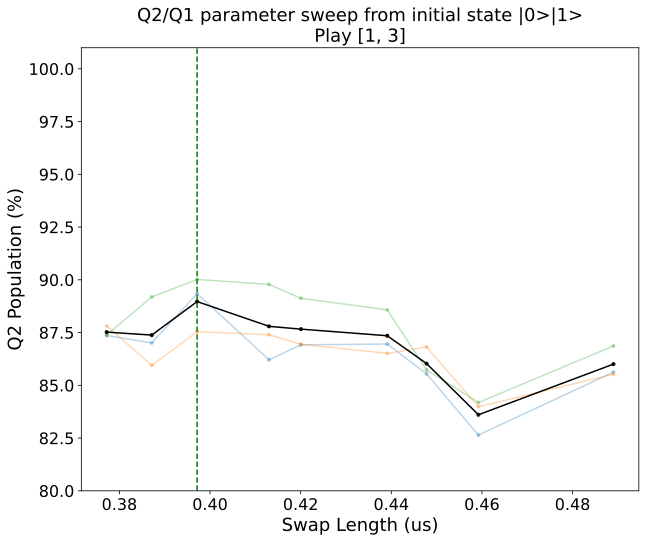

In [58]:
# plt.plot(opt_lens, all_fids_rot, label='Q2 measured fidelity')
# plt.plot(opt_lens, all_epop, label=f'Q{qubit} e', marker='.')
saveplot = False
# plot_filename = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\QramProtocol_EgGfsweepQ2_1QTomoQ2.svg'
# plot_filename = 'S:\Connie\experiments\qramLL_4QR2\data\data_240218\\QramProtocol_EgGfsweepQ3_1QTomoQ3.svg'
if saveplot: plt.style.use('dark_background')
else: plt.style.use('default')

plt.figure(figsize=(10, 8))
# if saveplot: plt.axhline(50, color='w', linestyle='-', linewidth=0.3)
# else: plt.axhline(50, color='k', linestyle='-', linewidth=0.3)
# plt.grid(linewidth=0.1)
all_epop_reshaped = np.reshape(all_epop, (len(all_epop)//len(opt_lens), len(opt_lens)))
for i_rep in range(data['num_repeat']):
    plt.plot(opt_lens, 100*all_epop_reshaped[i_rep], marker='.', alpha=0.3)
average_epop = np.average(all_epop_reshaped, axis=0)
if saveplot: plt.plot(opt_lens, 100*average_epop, 'w', marker='.')
else: plt.plot(opt_lens, 100*average_epop, 'k', marker='.')

# decay_time = 10e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

# decay_time = 1e3 # ns
# max_fid_times = np.linspace(0, max(opt_lens), 100)
# max_fids = np.exp(-max_fid_times/decay_time)
# plt.plot(max_fid_times, max_fids, '--', label=f'{decay_time/1e3} us decay')

# best_ind = np.argmin(np.abs(average_epop-50))
# best_ind = np.argmin(np.abs(average_epop - 0))
best_ind = np.argmax(np.abs(average_epop - 0))
# best_ind = 0
best_len = opt_lens[best_ind]
best_freq = opt_freqs[best_ind]
best_gain = gain_sweep[best_ind]
print('best vals:')
print(f'gain: pi_EgGf_Q.gain[{sweep2Q_q}] = {best_gain}')
print(f'len: pi_EgGf_Q.sigma[{sweep2Q_q}] = {best_len}')
print(f'freq: f_EgGf_Q[{sweep2Q_q}] = {best_freq}')
print(f'best population (%): {100*average_epop[best_ind]}')

plot_qubit = AttrDict(attrs['config']).expt.qubit
if not saveplot: plt.axvline(best_len, color='g', linestyle='--')
plt.xlabel(f'Swap Length (us)', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel(f'Q{plot_qubit} Population (%)', fontsize=18)
plt.yticks(fontsize=16)
plt.title(f'Q{sweep2Q_q}/Q1 parameter sweep from initial state {init_state}\nPlay {play_pulses}', fontsize=18)
# plt.ylim(40, 60)
# plt.ylim(-1, 20)
plt.ylim(80, 101)
# plt.legend()

if saveplot:
    plt.savefig(plot_filename, format='svg', bbox_inches='tight', transparent=True)
    print('Saved', plot_filename)

print('From saved files:')
print(saved_file)

plt.show()

Use for when actually did a gain sweep with fixed other parameters:

In [ ]:
# gain_sweep = np.linspace(0, 12208, 5)
all_epop_reshaped = np.reshape(all_epop, (len(all_epop)//len(gain_sweep), len(gain_sweep)))

plt.figure(figsize=(8, 6))
for i_rep in range(num_repeat):
    plt.plot(gain_sweep, 100*all_epop_reshaped[i_rep], marker='.', alpha=0.3)

average_epop = np.average(all_epop_reshaped, axis=0)
if saveplot: plt.plot(gain_sweep, 100*average_epop, 'w', marker='.')
else: plt.plot(gain_sweep, 100*average_epop, 'k', marker='.')
plt.xlabel('Gain', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel(f'Q{plot_qubit} Population (%)', fontsize=18)
plt.yticks(fontsize=16)
plt.title(f'Q{sweep2Q_q}/Q1 sweep, init {init_state}, fixed freq, len', fontsize=18)
# plt.ylim(40, 60)
plt.ylim(-1, 10)

print('From saved files:')
print(saved_files[0])
print('...')
print(saved_files[-1])
print('end population', 100*average_epop[-1] - 100*average_epop[0])

plt.show()

Use for when actually did a freq sweep with fixed other parameters:

In [ ]:
# freq_sweep = np.linspace(0, 12208, 5)
all_epop_reshaped = np.reshape(all_epop, (len(all_epop)//len(opt_freqs), len(opt_freqs)))

plt.figure(figsize=(8, 6))
for i_rep in range(num_repeat):
    plt.plot(opt_freqs, 100*all_epop_reshaped[i_rep], marker='.', alpha=0.3)

average_epop = np.average(all_epop_reshaped, axis=0)
if saveplot: plt.plot(opt_freqs, 100*average_epop, 'w', marker='.')
else: plt.plot(opt_freqs, 100*average_epop, 'k', marker='.')
plt.xlabel('Frequencies', fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel(f'Q{plot_qubit} Population (%)', fontsize=18)
plt.yticks(fontsize=16)
plt.title(f'Q{sweep2Q_q}/Q1 sweep, init {init_state}, fixed freq, len', fontsize=18)
# plt.ylim(40, 60)
# plt.ylim(-1, 20)

print('From saved files:')
print(saved_files[0])
print('...')
print(saved_files[-1])
print('end population', 100*average_epop[-1] - 100*average_epop[0])

plt.show()

# Repeat over time

In [246]:
apply_ps = False
ps_adjust = [-0.3, -1.0, -0.3, -0.3]
# ps_adjust = [np.inf]*4
ps_qubits = [0, 1, 2, 3]

In [ ]:
import time

start_time = time.time()

all_n_tomo = []
all_n_calib = []
all_fids = []
times = []

psi_id = psiZ[1].unit()
rho_id = qt.ket2dm(psi_id)

while time.time() - start_time < 2*60*60:
    times.append(time.time()-start_time)
    tomo = meas.StateTomography1QExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"StateTomoQ{qubit}",
        config_file=config_path,
    )

    tomo.cfg.expt = dict(
        reps=5000, # reps per measurement basis
        qubit=qubit,
    )

    tomo.go(analyze=False, display=False, progress=False, save=False)

    data = tomo.data
    cfg = tomo.cfg
    pulse_dict = tomo.pulse_dict
    assert np.all(np.array(tomo.meas_order) == meas_order)
    assert np.all(np.array(tomo.calib_order) == calib_order)

    n_tomo_raw, n_calib = tomo_analysis.n_tomo_calib_from_data(data, cfg, ps_adjust=ps_adjust, ps_qubits=ps_qubits, apply_ps=apply_ps, verbose=True)

    all_n_tomo.append(n_tomo_raw)
    all_n_calib.append(n_calib)

    rho_MLE = tomo_analysis.get_rho_from_counts(
        n_tomo_raw=n_tomo_raw,
        n_calib=n_calib,
        correct_readout=True,
        correct_neg_counts=True,
        method='analytical',
        ZZ_correction=False,
    )
    
    fid_base = qt.fidelity(qt.Qobj(rho_MLE, dims=rho_id.dims), rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
    tomo_analysis.show_plot_rho_2d(rho_MLE, rho_id, title=f'Base MLE (Q{qubit})', cmax=0.5)

    all_fids.append(fid_base)
    print(fid_base)

    time.sleep(60)

In [ ]:
print(all_fids)

In [ ]:
plt.figure(figsize=(15, 8))
plt.plot(times, all_fids)
plt.xlabel('Time (s)')
plt.show()